In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from scipy import stats
import scipy as sp
import os

import import_ipynb
import func_analysis
import func_format

import statsmodels.api as sm
import math
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import norm
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from func_analysis.ipynb
importing Jupyter notebook from func_format.ipynb


In [2]:
ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
date = ['13042019', '01102019', '27062020', '06072020']

LDAcorrect = []
LDArandomcorrect = []

#savepath = 'F:/BLAClustering_baseall/'
drive = 'F:/'
#func_format.foldercheck(savepath)
output = ['RatID', 'Date', 'Folder', 'Category', 'LDA Accuracy', 'Shuffle-LDA']
responsetype = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)

for r, rat in enumerate(ratID):
    neuronpath = drive+rat+'/Electrophys/'+date[r]+'/SpikeTimes/Neurons_BLA/'
    responsetype_perrat = responsetype[responsetype[:,0] == rat]
    
    try:
        neurondir = os.listdir(neuronpath)
    except:
        continue
        
    configpath = drive+rat+'/Parameters_'+date[r]+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    for f, folder in enumerate(foldername):
        behavior = np.load(drive+rat+'/TrackingData/AutoBehavior_06112020/'+date[r]+'/'+folder+'_bouttimes.npz')
        sync = np.loadtxt(drive+rat+'/Electrophys/'+date[r]+'/Sync/'+folder+'_frameSync.csv', delimiter = ',', dtype = np.float32)
        
        newbins = np.arange(intsync_start[f], intsync_stop[f]+.6, .5)
        basestart = intsync_start[f]-300
        basestop = intsync_start[f]
        
        try:
            social = behavior['social']
        except:
            try:
                social = np.vstack((behavior['rice1'], behavior['rice2']))
            except:
                social = np.vstack((behavior['rice1']))
        
        sociallabels = np.zeros(newbins.shape[0])
        for i, row in enumerate(social):
            start = np.argmin(np.abs(newbins - row[0]))
            stop = np.argmin(np.abs(newbins - row[1]))
            sociallabels[start:stop] = 1
            
        spikearray = np.zeros((len(newbins), len(os.listdir(neuronpath))))
        spikearray_zscore = np.zeros((len(newbins), len(os.listdir(neuronpath))))
        
        start = newbins[0]
        stop = newbins[-1]+.6
        
        for n, neuron in enumerate(neurondir):
            if neuron[-4:] != '.npy':
                continue
            neu = np.load(neuronpath+neuron)/1000
            spikes = func_analysis.extractSpikes(neu, start, stop)
            fr = func_analysis.firingrate(spikes, 0.5, start, stop, smooth=False)
            
            basespikes = func_analysis.extractSpikes(neu, basestart, basestop)
            basefr = func_analysis.firingrate(basespikes, 0.5, basestart, basestop, smooth=False)
            zfr = (fr - np.mean(basefr)/np.std(basefr))
            spikearray_zscore[:,n] = zfr
            
            spikearray[:,n] = fr
            
            
        spikesum = np.nansum(spikearray, axis = 0)
        rmv_lowspikes = np.where(spikesum < 50)
        spikearray = np.delete(spikearray, rmv_lowspikes, 1)
        spikearray_zscore = np.delete(spikearray_zscore, rmv_lowspikes, 1)
        try:
            nanremoval = np.unique(np.where(np.isnan(spikearray_zscore))[1])
            spikearray_zscore = np.delete(spikearray_zscore, nanremoval, 1)
        except:
            b = 1
        X = spikearray_zscore ### change this to spikearray to switch between zscored and not zscored
        y = sociallabels
                
        #bins_before = 1
        #bins_after = 1
        #bins_current = 1
        
        #N = bins_before+bins_current+bins_after
        #neuronnum = X.shape[1]
        #X_binned = np.empty([X.shape[0]-N+1, neuronnum])
        
        #for i in range(neuronnum):
            #X_binned[:,i] = N*np.convolve(X[:,i], np.ones((N,))/N, mode = 'valid')
        #X_binned = X_binned.astype(int)
        #y = y[bins_before:-bins_after]
        
        X_binned = X ### change this to bring back binning of data
        n_folds = 5
        cv = KFold()
        ypred_LDA = np.zeros(y.shape)
        ypred_SVC = np.zeros(y.shape)
        ypredrandom_LDA = np.copy(ypred_LDA)
        ypredrandom_SVC = np.copy(ypred_SVC)
        
        randomy = np.random.permutation(y)
        
        for i, (train_ind, test_ind) in enumerate(cv.split(X_binned, y)):
    
            Xtrain = X_binned[train_ind]
            Xtest = X_binned[test_ind]
            ytrain = y[train_ind]
            ytrain_random = randomy[train_ind]

            ## Linear Discriminant Analysis
            lda = LinearDiscriminantAnalysis()
            lda.fit(Xtrain, ytrain)
            ypred_LDA[test_ind] = lda.predict(Xtest)

            ### randomized values
            lda_random = LinearDiscriminantAnalysis()
            lda_random.fit(Xtrain, ytrain_random)
            ypredrandom_LDA[test_ind] = lda_random.predict(Xtest)

        LDAcorrect = np.append(LDAcorrect, metrics.roc_auc_score(y, ypred_LDA))
        LDArandomcorrect = np.append(LDArandomcorrect, metrics.roc_auc_score(randomy, ypredrandom_LDA))
        
        save = np.hstack((rat, date[r], folder, intcat[f], metrics.roc_auc_score(y, ypred_LDA), metrics.roc_auc_score(randomy, ypredrandom_LDA)))
        
        output = np.vstack((output, save))
        
#np.savetxt(savepath+'PerTrialResults.csv', output, delimiter = ',', fmt = '%s')

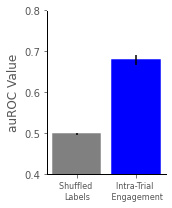

In [4]:
fig, ax = plt.subplots(1, figsize = (2.5,3))

ax.bar((0,1), (np.mean(LDArandomcorrect), np.mean(LDAcorrect)), color = ('gray', 'blue'), edgecolor = ('gray', 'blue'), lw = 1.5, yerr = (stats.sem(LDArandomcorrect), stats.sem(LDAcorrect)))
#ax.scatter(np.ones(len(LDAcorrect)), LDAcorrect, color = 'black', s = 10, zorder = 6)
#ax.scatter(np.zeros(len(LDArandomcorrect)), LDArandomcorrect, color = 'black', s = 10, zorder = 6)
ax.set_xticks((0,1))
ax.set_xticklabels(('Shuffled \nLabels', 'Intra-Trial \n Engagement'), fontsize = 8)
ax.set_ylabel('auROC Value')
ax.set_ylim(.4, .8)
ax.set_yticks((.4, .5, .6, .7, .8))
ax.set_xlim(-.5, 1.5)
ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
plt.grid(False)
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(savepath+'F5_engagementwithstimulus_allneurons.png', dpi = 300)
#plt.savefig(savepath+'LDAdecoding_socialvsnonsocial_allneurons.svg', format = 'svg', dpi = 500, transparent = True)
#plt.savefig(savepath+'LDAdecoding_socialvsnonsocial_allneurons.png', dpi = 300)

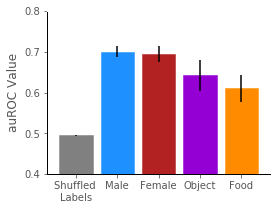

In [4]:
male = np.array(output[output[:,3] == 'Male'][:,-2], float)
female = np.array(output[output[:,3] == 'Female'][:,-2], float)
obj = np.array(output[output[:,3] == 'Object'][:,-2], float)
food = np.array(output[output[:,3] == 'Food'][:,-2], float)

fig, ax = plt.subplots(1, figsize = (4,3))

ax.bar((0,1,2,3,4), (np.mean(LDArandomcorrect), np.mean(male), np.mean(female), np.mean(obj), np.mean(food)), color = ('gray', 'dodgerblue', 'firebrick', 'darkviolet', 'darkorange'), edgecolor = ('gray', 'dodgerblue', 'firebrick', 'darkviolet', 'darkorange'), yerr = (stats.sem(LDArandomcorrect), stats.sem(male), stats.sem(female), stats.sem(obj), stats.sem(food)))

ax.set_ylabel('auROC Value')
ax.set_xticks((0,1,2,3,4))
ax.set_xticklabels(('Shuffled \nLabels', 'Male', 'Female', 'Object', 'Food'))
ax.set_xlim(-.7, 4.7)
ax.set_ylim(.4, .8)
ax.set_yticks((.4, .5, .6, .7, .8))
ax.grid(False)
ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(savepath+'F5_engagementperstimulus_allneurons.png', dpi = 300)
plt.savefig('F:/Figure4/LDAdecoding_socialvsnonsocial_allneurons_permodality.svg', format = 'svg', dpi = 500, transparent = True)
#plt.savefig(savepath+'LDAdecoding_socialvsnonsocial_perinttype.png', dpi = 300)

In [10]:
for i, ii in enumerate(output[output[:,3] == 'Food'][:,-2]):
    print(ii)

0.5691620624888609
0.6341814438188083
0.5694447694143522
0.5737425553694397
0.7067952823556979
0.7791895382628351
0.4893678068020174
0.5653389143937348


In [ ]:
def engagement_LDA_5fold(X_binned, y):
    n_folds = 5
    cv = KFold()
    
    ypred_LDA = np.zeros(y.shape)
    
    for i, (train_ind, test_ind) in enumerate(cv.split(X_binned, y)):
        
        Xtrain = X_binned[train_ind]
        Xtest = X_binned[test_ind]
        ytrain = y[train_ind]
        
        lda = LinearDiscriminantAnalysis()
        lda.fit(Xtrain, ytrain)
        ypred_LDA[test_ind] = lda.predict(Xtest)
        
    return(ypred_LDA)
        
ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
date = ['13042019', '01102019', '27062020', '06072020']
drive = 'F:/'


#responsetype = np.loadtxt('D:/Summary/NeuronResponseType/neuronresponsetype.csv', delimiter = ',', dtype = str)
#category = 'noresponse'

#savepath = 'F:/Decode_socialbehavior/'
#func_format.foldercheck(savepath)
#output = ['RatID', 'Date', 'Folder', 'Category', 'LDA 2neurons', 'LDA 5neurons', 'LDA 10neurons', 'LDA 20neurons']
output = np.zeros(32)


for r, rat in enumerate(ratID):
    neuronpath = drive+rat+'/Electrophys/'+date[r]+'/SpikeTimes/Neurons_BLA/'
    
    try:
        neurondir = os.listdir(neuronpath)
    except:
        continue
        
    #responsetypeday = responsetype[responsetype[:,1] == date[r]]
    configpath = drive+rat+'/Parameters_'+date[r]+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    for f, folder in enumerate(foldername):
        behavior = np.load(drive+rat+'/TrackingData/AutoBehavior_06112020/'+date[r]+'/'+folder+'_bouttimes.npz')
        sync = np.loadtxt(drive+rat+'/Electrophys/'+date[r]+'/Sync/'+folder+'_frameSync.csv', delimiter = ',', dtype = np.float32)
        
        newbins = np.arange(intsync_start[f], intsync_stop[f]+.6, .5)
        
        try:
            social = behavior['social']
        except:
            try:
                social = np.vstack((behavior['rice1'], behavior['rice2']))
            except:
                social = np.vstack((behavior['rice1']))
        
        sociallabels = np.zeros(newbins.shape[0])
        for i, row in enumerate(social):
            start = np.argmin(np.abs(newbins - row[0]))
            stop = np.argmin(np.abs(newbins - row[1]))
            sociallabels[start:stop] = 1
        
        #responselist = responsetypeday[responsetypeday[:,-1] == category]
        
        
        spikearray = np.zeros((len(newbins), len(os.listdir(neuronpath))))
        
        start = newbins[0]
        stop = newbins[-1]+.6
        
        
        
        for n, neuron in enumerate(neurondir):
            if neuron[-4:] != '.npy':
                continue
            neu = np.load(neuronpath+neuron)/1000
            spikes = func_analysis.extractSpikes(neu, start, stop)
            fr = func_analysis.firingrate(spikes, 0.5, start, stop, smooth=False)
            spikearray[:,n] = fr
            
        spikesum = np.nansum(spikearray, axis = 0)
        rmv_lowspikes = np.where(spikesum < 50)
        spikearray = np.delete(spikearray, rmv_lowspikes, 1)
        X = spikearray
        y = sociallabels
        
        bins_before = 1
        bins_after = 1
        bins_current = 1
        
        N = bins_before+bins_current+bins_after
        neuronnum = X.shape[1]
        X_binned = np.empty([X.shape[0]-N+1, neuronnum])
        
        neuronlist_indices = np.arange(neuronnum)
        for i in range(neuronnum):
            X_binned[:,i] = N*np.convolve(X[:,i], np.ones((N,))/N, mode = 'valid')
            
        X_binned = X_binned.astype(int)
        y = y[bins_before:-bins_after]
        
        increasingneuronnum = np.arange(2,neuronnum)
        
        allaverage = np.zeros(len(np.arange(2,neuronnum)))
        for j, number in enumerate(increasingneuronnum):
            
            choices = np.random.choice(neuronlist_indices, replace = True, size = (500, number))
            LDAcorrectxneurons = []
            for x, selection in enumerate(choices):
                selected_X = X_binned[:, selection]
                ypred_LDA = engagement_LDA_5fold(selected_X, y)
                
                LDAcorrectxneurons = np.append(LDAcorrectxneurons, metrics.roc_auc_score(y, ypred_LDA))
                
            averageLDAxneurons = np.mean(LDAcorrectxneurons)
            
            allaverage[j] = averageLDAxneurons
            
        save = np.hstack((rat, date[r], folder, intcat[f], allaverage))
        np.savetxt('F:/Figure4_S10_LDAengagement/'+rat+'_'+folder+'.csv', save, delimiter = ',', fmt = '%s')
        print(rat+' '+intcat[f]+' completed')
        
        #output = np.vstack((output, save))
            
       
        
#np.savetxt(savepath+'PerTrialResults_differentneuronnumber.csv', output, delimiter = ',', fmt = '%s')

Amygdala6 Male completed
Amygdala6 Object completed
Amygdala6 Male completed
Amygdala6 Food completed


In [7]:
np.savetxt('F:/F5_S_increasingneuronnumberresults.csv', output, delimiter = ',', fmt = '%s')

In [5]:
choices

array([[46, 21, 24, ..., 16, 28, 24],
       [43, 25, 31, ..., 27, 12, 13],
       [36, 40, 37, ..., 18, 38, 46],
       ...,
       [23, 26, 29, ..., 10,  4, 36],
       [23, 41, 32, ...,  1, 21, 26],
       [ 1, 23, 40, ..., 12, 16, 39]])

In [28]:
originalvalues = np.loadtxt('F:/Figure4/Decode_socialbehavior/PerTrialResults.csv', delimiter = ',', dtype = str)

In [29]:
shuffledneurons = np.array(originalvalues[1:,5], float)
neurons2 = np.array(output[1:,4], float)
neurons5 = np.array(output[1:,5], float)
neurons10 = np.array(output[1:, 6], float)
neurons20 = np.array(output[1:,7], float)
allneurons = np.array(originalvalues[1:,4], float)

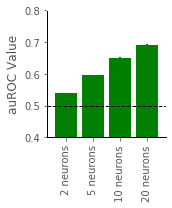

In [31]:
fig, ax = plt.subplots(1, figsize = (2.5,3))

ax.bar((0,1,2,3), 
       (np.mean(neurons2), np.mean(neurons5), np.mean(neurons10), np.mean(neurons20)), color = ('green'), yerr = (stats.sem(neurons2), stats.sem(neurons5), stats.sem(neurons10), stats.sem(neurons20)))


#ax.scatter(np.zeros(len(neurons2)), neurons2, color = 'black', s = 10, zorder = 6)
#ax.scatter(np.full(len(neurons5), 1), neurons5, color = 'black', s = 10, zorder = 6)
#ax.scatter(np.full(len(neurons10), 2), neurons10, color = 'black', s = 10, zorder = 6)
#ax.scatter(np.full(len(neurons20), 3), neurons20, color = 'black', s = 10, zorder = 6)

ax.set_ylabel('auROC Value')
ax.set_xticks((0,1,2,3))
ax.set_xticklabels(('2 neurons', '5 neurons', '10 neurons', '20 neurons'), rotation = 90)
ax.set_xlim(-.7, 3.7)
ax.set_ylim(.4, .8)
ax.set_yticks((.4, .5, .6, .7, .8))
ax.grid(False)

ax.plot((-.7, 3.7), (.5, .5), color = 'k', linestyle = '--', lw = 1)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.set_facecolor('white')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(savepath+'LDAdecoding_socialvsnonsocial_allneurons_differentneuronnum.svg', format = 'svg', dpi = 500, transparent = True)
#plt.savefig('F:/Figure4/Decode_socialbehavior/increasing_neuronnumber.png', dpi = 300)
#plt.savefig(savepath+'LDAdecoding_socialvsnonsocial_perinttype.png', dpi = 300)

In [32]:
savepath

'F:/Decode_socialbehavior/'

In [107]:
responsetype = np.loadtxt('D:/Summary/NeuronResponseType/neuronresponsetype.csv', delimiter = ',', dtype = str)

In [112]:
responsetype = responsetype[responsetype[:,1] == date[r]]

In [138]:
ratID = ['Amygdala6', 'Amygdala6', 'Amygdala8', 'Amygdala8', 'Amygdala8']
date = ['13042019', '14042019', '01102019', '02102019', '03102019']


In [177]:
LDAcorrect = []
LDArandomcorrect = []
SVCcorrect = []
SVCrandomcorrect = []

output = ['RatID', 'Date', 'Folder', 'Category', 'LDA Accuracy', 'Shuffle-LDA', 'SVC Accuracy', 'Shuffle_SVC']
responsetype = np.loadtxt('D:/Summary/NeuronResponseType/neuronresponsetype.csv', delimiter = ',', dtype = str)
category = 'noresponse'


for r, rat in enumerate(ratID):
    configpath = 'D:/'+rat+'/Parameters_'+date[r]+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    responsetypeday = responsetype[responsetype[:,1] == date[r]]
    
    for f, folder in enumerate(foldername):
        behavior = np.load('D:/'+rat+'/TrackingData/Behavior_analyzed/'+date[r]+'/'+folder+'_bouttimes.npz')
        sync = np.loadtxt('D:/'+rat+'/Electrophys/'+date[r]+'/Sync/'+folder+'_frameSync.csv', delimiter = ',', dtype = np.float32)
        
        newbins = np.arange(intsync_start[f], intsync_stop[f]+.6, .5)
        
        try:
            social = behavior['social']
        except:
            print('nonsocial')
            #print(rat, date[r], folder, intcat[f])
            continue
        
        sociallabels = np.zeros(newbins.shape[0])
        for i, row in enumerate(social):
            start = np.argmin(np.abs(newbins - row[0]))
            stop = np.argmin(np.abs(newbins - row[1]))
            sociallabels[start:stop] = 1
            
        neuronpath = 'D:/'+rat+'/Electrophys/'+date[r]+'/SpikeTimes/Neurons_rename/'
        responselist = responsetypeday[responsetypeday[:,-1] == category]
        spikearray = np.zeros((len(newbins), len(responselist)))
        
        start = newbins[0]
        stop = newbins[-1]+.6
        index = 0
        
        for n, neuron in enumerate(os.listdir(neuronpath)):
            response = responsetypeday[responsetypeday[:,2] == neuron[:-4]][-1][-1]
            if response != category:
                continue
            
            #print(response)
            neu = np.load(neuronpath+neuron)/1000
            spikes = func_analysis.extractSpikes(neu, start, stop)
            fr = func_analysis.firingrate(spikes, 0.5, start, stop, smooth=False)
            spikearray[:,index] = fr
            index = index+1
            
        #spikesum = np.nansum(spikearray, axis = 0)
        #rmv_lowspikes = np.where(spikesum < 50)
        #spikearray = np.delete(spikearray, rmv_lowspikes, 1)
        X = spikearray
        y = sociallabels
        
        bins_before = 1
        bins_after = 1
        bins_current = 1
        
        N = bins_before+bins_current+bins_after
        neuronnum = X.shape[1]
        X_binned = np.empty([X.shape[0]-N+1, neuronnum])
        
        for i in range(neuronnum):
            X_binned[:,i] = N*np.convolve(X[:,i], np.ones((N,))/N, mode = 'valid')
        X_binned = X_binned.astype(int)
        y = y[bins_before:-bins_after]
        
        n_folds = 5
        cv = KFold()
        ypred_LDA = np.zeros(y.shape)
        ypred_SVC = np.zeros(y.shape)
        ypredrandom_LDA = np.copy(ypred_LDA)
        ypredrandom_SVC = np.copy(ypred_SVC)
        
        randomy = np.random.permutation(y)
        
        for i, (train_ind, test_ind) in enumerate(cv.split(X_binned, y)):
    
            Xtrain = X_binned[train_ind]
            Xtest = X_binned[test_ind]
            ytrain = y[train_ind]
            ytrain_random = randomy[train_ind]

            ## Linear Discriminant Analysis
            lda = LinearDiscriminantAnalysis()
            lda.fit(Xtrain, ytrain)
            ypred_LDA[test_ind] = lda.predict(Xtest)

            ##SVC
            svc = SVC()
            svc.fit(Xtrain, ytrain)
            ypred_SVC[test_ind] = svc.predict(Xtest)

            ### randomized values
            lda_random = LinearDiscriminantAnalysis()
            lda_random.fit(Xtrain, ytrain_random)
            ypredrandom_LDA[test_ind] = lda_random.predict(Xtest)

            svc_random = SVC()
            svc_random.fit(Xtrain, ytrain_random)
            ypredrandom_SVC[test_ind] = svc_random.predict(Xtest)

        LDAcorrect = np.append(LDAcorrect, metrics.balanced_accuracy_score(y, ypred_LDA))
        LDArandomcorrect = np.append(LDArandomcorrect, metrics.balanced_accuracy_score(randomy, ypredrandom_LDA))
        
        SVCcorrect = np.append(SVCcorrect, metrics.balanced_accuracy_score(y, ypred_SVC))
        SVCrandomcorrect = np.append(SVCrandomcorrect, metrics.balanced_accuracy_score(randomy, ypredrandom_SVC))
        
        save = np.hstack((rat, date[r], folder, intcat[f], metrics.balanced_accuracy_score(y, ypred_LDA), metrics.balanced_accuracy_score(randomy, ypredrandom_LDA), metrics.balanced_accuracy_score(y, ypred_SVC), metrics.balanced_accuracy_score(randomy, ypredrandom_SVC)))
        
        output = np.vstack((output, save))

nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial
nonsocial


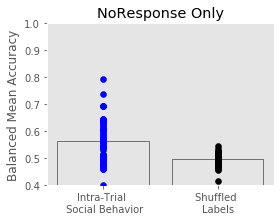

In [178]:
fig, ax = plt.subplots(1, figsize = (4,3))

ax.bar((0,1), (np.mean(LDAcorrect), np.mean(LDArandomcorrect)), edgecolor = 'black', facecolor = 'none')
ax.scatter(np.zeros(len(LDAcorrect)), LDAcorrect, color = 'blue', zorder = 6)
ax.scatter(np.ones(len(LDArandomcorrect)), LDArandomcorrect, color = 'black', zorder = 6)
ax.set_xticks((0,1))
ax.set_xticklabels(('Intra-Trial \n Social Behavior', 'Shuffled \nLabels'))
ax.set_ylabel('Balanced Mean Accuracy')
ax.set_ylim(.4, 1)
plt.grid(False)
plt.tight_layout()
plt.title('NoResponse Only')

plt.savefig(savepath+'LDAdecoding_socialnonsocial_noresponse.png', dpi = 300)


In [179]:
np.savetxt(savepath+'PerTrialResults_noresponseonly.csv', output, delimiter = ',', fmt = '%s')

In [188]:
multimodal = np.loadtxt(savepath+'PerTrialResults_multimodalonly.csv', delimiter = ',', dtype = str)
LDAmultimodal = np.array(multimodal[1:,4], np.float32)
unimodal = np.loadtxt(savepath+'PerTrialResults_unimodalonly.csv', delimiter = ',', dtype = str)
LDAunimodal = np.array(unimodal[1:,4], np.float32)
inconsistent = np.loadtxt(savepath+'PerTrialResults_inconsistentonly.csv', delimiter = ',', dtype = str)
LDAinconsistent = np.array(inconsistent[1:,4], np.float32)
noresponse = np.loadtxt(savepath+'PerTrialResults_noresponseonly.csv', delimiter = ',', dtype = str)
LDAnoresponse = np.array(noresponse[1:,4], np.float32)
allneurons = np.loadtxt(savepath+'PerTrialResults.csv', delimiter = ',', dtype = str)
LDAall = np.array(allneurons[1:,4], np.float32)

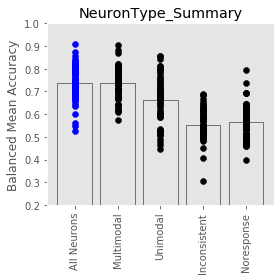

In [196]:
fig, ax = plt.subplots(1, figsize = (4,4))

ax.bar((0,1,2,3,4), (np.mean(LDAall), np.mean(LDAmultimodal), np.mean(LDAunimodal), np.mean(LDAinconsistent), np.mean(LDAnoresponse)), edgecolor = 'black', facecolor = 'none')
ax.scatter(np.zeros(len(LDAall)), LDAall, color = 'blue', zorder = 6)
ax.scatter(np.ones(len(LDAmultimodal)), LDAmultimodal, color = 'black', zorder = 6)
ax.scatter(np.full(len(LDAunimodal),2), LDAunimodal, color = 'black', zorder = 6)
ax.scatter(np.full(len(LDAinconsistent), 3), LDAinconsistent, color = 'black', zorder = 6)
ax.scatter(np.full(len(LDAnoresponse), 4), LDAnoresponse, color = 'black', zorder = 6)
ax.set_xticks((0,1,2,3,4))
ax.set_xticklabels(('All Neurons', 'Multimodal', 'Unimodal', 'Inconsistent', 'Noresponse'), rotation = 90)
ax.set_ylabel('Balanced Mean Accuracy')
ax.set_ylim(.2, 1)
plt.grid(False)
plt.title('NeuronType_Summary')
plt.tight_layout()

plt.savefig(savepath+'LDAdecoding_socialvsnonsocial_neurongroupcomparison.png', dpi = 300)
